In [40]:
import gzip
# from BCBio.GFF import GFFExaminer
from pprint import pprint
from imp import reload
import pandas


import pygbrowse

In [9]:
examiner = GFFExaminer()

gff_handle = gzip.open(gff3_fname)

pprint(examiner.available_limits(gff_handle))

## Download GFF3 file

## Just plot gene models

In [4]:
import pandas

In [37]:
%%time
gff3_fname = '/home/dskola/glass_home/model_data/reference_genomes/mm10/Mus_musculus.GRCm38.84.chr.gff3.gz'
assert gzip.open(gff3_fname).readline().decode().strip() == '##gff-version   3', 'First line does not indicate a GFF3 file. Currently only GFF3 annotations are supported.'
gff_data = pandas.read_csv(gff3_fname,
                           sep='\t',
                           comment='#', 
                           header=None, 
                           names=['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'],
                           dtype={'seqid':str, 'source':str, 'type':str, 'start':int, 'end':int, 'score':str, 'strand':str, 'phase':str, 'attributes':str})


CPU times: user 5.96 s, sys: 1.12 s, total: 7.09 s
Wall time: 18.5 s


In [38]:
gff_data.dtypes

seqid         object
source        object
type          object
start          int64
end            int64
score         object
strand        object
phase         object
attributes    object
dtype: object

In [73]:
reload(pygbrowse)
reload(pygbrowse.plots)

<module 'pygbrowse.plots' from '/home/dskola/workspace/python-genome-browser/pygbrowse/plots.py'>

In [74]:
%time gene_models = pygbrowse.plots.GeneModels(gff3_fname)

2018-Jul-23 09:37:38	Loading gene model information from /home/dskola/glass_home/model_data/reference_genomes/mm10/Mus_musculus.GRCm38.84.chr.gff3.gz. This may take a few minutes ...
CPU times: user 1min 36s, sys: 54.2 s, total: 2min 31s
Wall time: 10min 24s


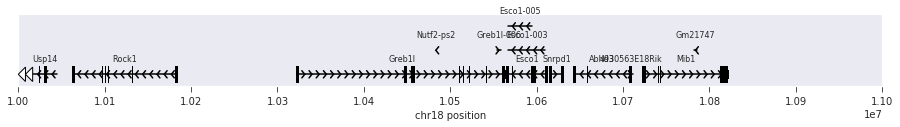

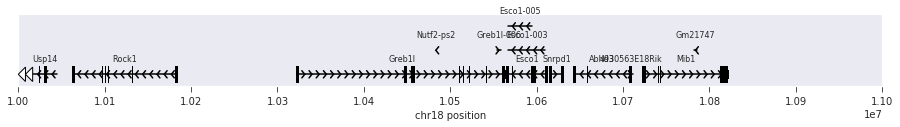

In [75]:
pygbrowse.plots.visualize(plot_objects=[[gene_models]], chrom='chr18', ws=10000000, we=11*1e6)

## Continuous data

## Idea: Leave the tag data on disk and create vectors on the fly. Would need to grab the appropriate chromosome file and then do a binary search to find the correct start point (then iterate until end). We could do something similar for gene models

In [195]:
reload(pygbrowse.plots)
from pygbrowse.plots import *

reload(pygbrowse.utilities)
from pygbrowse.utilities import *

In [94]:
test_tags = pandas.read_csv(tag_filename, sep='\t', names=['_', 'chrom', 'start', 'end', 'strand', 'density', 'readlen'])

In [97]:
import numpy
numpy.searchsorted(test_tags.start, target)

array([14899])

In [99]:
test_tags.iloc[14899-1:]

,_,chrom,start,end,strand,density,readlen
14898,NaN,chr1,9997945,1,3.0,55,NaN
14899,NaN,chr1,10021267,1,1.0,55,NaN
14900,NaN,chr1,10024700,1,3.0,52,NaN
14901,NaN,chr1,10024724,1,1.0,55,NaN
14902,NaN,chr1,10024831,1,2.0,55,NaN
14903,NaN,chr1,10024865,1,1.0,55,NaN
14904,NaN,chr1,10024891,1,4.0,55,NaN
14905,NaN,chr1,10024893,1,3.0,39,NaN
14906,NaN,chr1,10024893,1,1.0,55,NaN
14907,NaN,chr1,10024896,1,1.0,55,NaN


In [194]:
import os
tag_filename = '/home/dskola/glass_data/mm10/Microglia/RNA/C57_Microglia_RNA_PolyA_PND65_LPS_1mgkg_7d_DGO_150918_15_10_09/chr1.tags.tsv'
filesize = os.path.getsize(tag_filename)
search_window_start = 0
search_window_end = filesize
guess = int((search_window_start + search_window_end) / 2)

iter_count = 0
target = 10000000
found = False
last_start = 0

with open(tag_filename, 'rt') as tag_file:
    while search_window_end - search_window_start > 1:
        tag_file.seek(guess)
        _ = tag_file.readline() # read forward to get to a line start
        thisline = tag_file.readline()
        _, chrom, start, strand, count, readlen = thisline.split('\t')
        start = int(start)

        print(search_window_start, search_window_end, guess, start, thisline)

        if start < target:
            search_window_start = guess
        elif start >= target:
            search_window_end = guess 

        guess = int((search_window_start + search_window_end) / 2)
print(guess, start, thisline)

0 19584779 9792389 127915696 	chr1	127915696	0	1.0	25

0 9792389 4896194 63731931 	chr1	63731931	0	2.0	55

0 4896194 2448097 38054117 	chr1	38054117	1	2.0	34

0 2448097 1224048 34263424 	chr1	34263424	0	3.0	55

0 1224048 612024 13652224 	chr1	13652224	0	2.0	20

0 612024 306012 9849097 	chr1	9849097	0	3.0	55

306012 612024 459018 13141939 	chr1	13141939	1	1.0	53

306012 459018 382515 10121185 	chr1	10121185	0	1.0	55

306012 382515 344263 10025480 	chr1	10025480	1	1.0	55

306012 344263 325137 9891429 	chr1	9891429	0	1.0	22

325137 344263 334700 9899550 	chr1	9899550	0	1.0	54

334700 344263 339481 9910204 	chr1	9910204	0	1.0	55

339481 344263 341872 9944043 	chr1	9944043	1	1.0	55

341872 344263 343067 10024921 	chr1	10024921	1	4.0	55

341872 343067 342469 9962284 	chr1	9962284	1	1.0	55

342469 343067 342768 10024700 	chr1	10024700	1	3.0	52

342469 342768 342618 9964251 	chr1	9964251	1	2.0	55

342618 342768 342693 9967818 	chr1	9967818	1	1.0	55

342693 342768 342730 9997945 	chr1	9997945	1

In [131]:
with open(tag_filename, 'rt') as tag_file:

    x = tag_file.readlines()

In [193]:
%time res = binary_search_tag_file(tag_filename, 10000000)
print(res)


initial guess: 9792389
discarded: 5	0	3.0	26
line: chr1	127915696	0	1.0	25
0 9792389 19584778 127915696

initial guess: 4896194
discarded: .0	55
line: chr1	63731931	0	2.0	55
0 4896194 9792389 63731931

initial guess: 2448097
discarded: 1.0	32
line: chr1	38054117	1	2.0	34
0 2448097 4896194 38054117

initial guess: 1224048
discarded: chr1	34263424	0	1.0	54
line: chr1	34263424	0	3.0	55
0 1224048 2448097 34263424

initial guess: 612024
discarded: 652205	1	1.0	55
line: chr1	13652224	0	2.0	20
0 612024 1224048 13652224

initial guess: 306012
discarded: 54
line: chr1	9849097	0	3.0	55
0 306012 612024 9849097

initial guess: 459018
discarded: 3141938	1	2.0	46
line: chr1	13141939	1	1.0	53
306012 459018 612024 13141939

initial guess: 382515
discarded: 1.0	54
line: chr1	10121185	0	1.0	55
306012 382515 459018 10121185

initial guess: 344263
discarded: 55
line: chr1	10025480	1	1.0	55
306012 344263 382515 10025480

initial guess: 325137
discarded: 891426	0	3.0	25
line: chr1	9891429	0	1.0	22
306012 3

In [177]:
reload(pygbrowse.utilities )
from pygbrowse.utilities import *

In [172]:
with open(tag_filename, 'rt') as tag_file:
    tag_file.seek(0)
    print(tag_file.readline())

	chr1	3066319	0	1.0	55



In [ ]:
class WigPlot(_BrowserSubPlot):
    def __init__(self, chromosome_series, label=None, color=None, center=False, scale=False, ylim=None,
                 convolution_kernel=None):
        super(WigPlot, self).__init__()
        self.color = color
        self.vector = vector_series
        self.center = center
        self.scale = scale
        self.label = label
        self.convolution_kernel = convolution_kernel
        self.ylim = ylim
        self.normalization_factor = 1
        
        
    @classmethod
    def from_data(cls, series_dict):
        self.data_type = 'local'
        self.data = chromosome_series
        pass        
        
    @classmethod
    def from_tag_directory(cls, path_to_tag_folder, normalize_to=10000000):
        new_object = cls()
        # store information about where to find our data when called upon to plot it.
        self.data_type = 'tag'
        self.data = path_to_tag_folder
        
        if normalize_to:
            # extract total tag count from tagInfo.txt
            tag_info_fname = os.path.join(path_to_tag_folder, 'tagInfo.txt')
            with open(tag_info_fname, 'rt') as tag_info_file:
                sizeline = tag_info_file.readlines()[1].split('\t')
            assert sizeline[0] == 'genome'
            num_tags = int(sizeline[2])

            self.normalization_factor = self.num_tags / normalize_to

    @classmethod
    def from_wig_file(cls, path_to_wig_file):
        pass
            
    def _extract_from_tag_directory(self, chrom, ws, we, path_to_tag_directory):
        """
        Use binary search to quickly extract only the tags in the window :param:`chrom`,
        :param:`ws` - :param:`we`.
        
        """
        tag_filename = os.path.join(path_to_tag_directory, '{}.tags.tsv'.format(chrom))
        start_offset = binary_search_tag_file(tag_filename=tag_filename, search_target = ws)
        end_offset = binary_search_tag_file(tag_filename=tag_filename, search_target = we)
        
        with open(tag_filename, 'rt') as tag_file:
            for line_num, line in enumerate(tag_file):
                split_line = line.strip().split('\t')

                if len(line) > 0:
                    chrom = toolbox.convert_chroms(split_line[0], dest=self.chromosome_dialect)
                    # print split_line
                    strand = strand_translator[split_line[2]]

                    if chrom in self.spileups:
                        read_length = int(split_line[4])
                        start_pos = int(split_line[1]) - 1

                        if strand == 1:
                            end_pos = start_pos + read_length
                        else:
                            end_pos = start_pos - read_length

                        num_reads = float(split_line[3])
                        assert 0 <= start_pos < self.chrom_lengths[
                            chrom], 'Read start position {} is out of bounds for chromosome {} with bounds [{},{}). Offending line: {}'.format(
                            start_pos, chrom, 0, self.chrom_lengths[chrom], line)
                        assert 0 <= end_pos < self.chrom_lengths[
                            chrom], 'Read end position {} is out of bounds for chromosome {} with bounds [{},{}), strand {} Offending line: {}'.format(
                            end_pos, chrom, 0, self.chrom_lengths[chrom], strand, line)

                        self.read_counts[chrom] += num_reads
                        self.total_read_density[chrom] += read_length * num_reads
                        self.read_length_counts[read_length] += num_reads

                        if (start_only and strand == 1) or (end_only and strand == -1):
                            self.spileups[chrom][strand][start_pos] += num_reads
                            # print 'read: {}, updating position {}'.format(line, start_pos)
                        elif (end_only and strand == 1) or (start_only and strand == -1):
                            self.spileups[chrom][strand][end_pos] += num_reads
                            # print 'read: {}, updating position {}'.format(line, end_pos)
                        else:
                            self.spileups[chrom][strand][start_pos:end_pos] += num_reads

                    else:
                        if chrom not in missing_chroms:
                            dbg_print('Chromosome {} not found in self!'.format(chrom), 1)
                            missing_chroms.add(chrom)
                    #            print '\tDone.'
    print('Done with tag directory')

    def plot(self, ax):
        if self.ylim:
            ylim = self.ylim
        else:
            ylim = ax.get_ylim()

        vert_span = (ylim[1] - ylim[0])
        vert_center = vert_span / 2 + ylim[0]

        this_plot_vector = self.vector.copy()

        if self.convolution_kernel is not None:
            this_plot_vector = pandas.Series(
                scipy.signal.convolve(this_plot_vector, self.convolution_kernel, mode='same'),
                index=this_plot_vector.index)

        if self.scale:
            this_plot_vector /= (this_plot_vector.max() - this_plot_vector.min())
            this_plot_vector *= vert_span

        if self.center:
            this_plot_vector -= this_plot_vector.mean()
            this_plot_vector += vert_center
        #         print(self.center, self.scale, vert_center, vert_span, this_plot_vector.min(), this_plot_vector.max())
        this_plot_vector = this_plot_vector.loc[
            (this_plot_vector.index >= self.ws) & (this_plot_vector.index < self.we)]
        ax.plot(this_plot_vector.index, this_plot_vector, color=self.color, label=self.label)
        ax.set_ylim(ylim)

In [ ]:

    strand_translator = {'0': 1, '1': -1}

    

    

In [ ]:
## Get total reads (for normalization) from tagInfo file.

In [ ]:
from pgtools import pileups

def load_tag_pileups(data_type, condition, strain, basepath='/home/dskola/projects/coupled_peaks/moremerged/pooled_tag_folders'):
    pileup_folder = '/home/dskola/data/scratch/dskola/pileups/{}_{}_{}'.format(data_type, condition, strain)
    os.makedirs(pileup_folder, exist_ok=True)
    try:
        this_pileup = pileups.Pileups.load(pileup_folder, 'r')
    except (IOError, FileNotFoundError, OSError):
        tag_folder = '/home/dskola/projects/coupled_peaks/moremerged/pooled_tag_folders/pooled_{}_{}_{}/'.format(data_type, condition, strain)
        this_pileup = pileups.StrandedPileups(mm10_genome.contig_lengths, build='mm10')
        this_pileup.load_from_homer_tag_directory(tag_folder)
        this_pileup = this_pileup.mixDown()
        this_pileup.__idiv__(this_pileup.total_reads / 10000000) 
        this_pileup.save(pileup_folder)
        this_pileup = pileups.Pileups.load(pileup_folder, 'r')
    return this_pileup

def generate_vis_from_pileup(pileup, chrom, ws, we):
    return pandas.Series(pileup.pileups[chrom][ws:we], index=numpy.arange(ws,we))

In [ ]:
tag_pileups = {}
for data_type in ('h3k27ac', 'rna', 'pu1', 'ctcf', 'atac'):
    if data_type not in tag_pileups:
        tag_pileups[data_type] = {}
    for condition in ('notx',):
        if condition not in tag_pileups[data_type]:
            tag_pileups[data_type][condition] = {}
        for strain in ('c57', 'balb'):
            if strain not in tag_pileups[data_type][condition]:
                tag_pileups[data_type][condition][strain] = load_tag_pileups(data_type, condition, strain)

In [ ]:
pu1_tags = pygbrowse.plots.WigPlot()